In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import csv
import sys
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy


from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings, param_ratios, plot_results
from training_script import train_SSN_vmap

#initialize key
key = random.PRNGKey(9)

jax backend cpu


In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 5

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

In [20]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
#sigEI, sigII = .2, .2
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)

#Excitatory and inhibitory constants for extra synaptic GABA
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0


#New parameter definition
ssn_layer_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2,  c_E = c_E, c_I = c_I)
readout_pars = dict(w_sig = w_sig, b_sig=b_sig)

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 1000, verbose=False, silent=True)
np.linalg.norm(readout_pars['w_sig'])

loss_pars = dict(lambda_1=1, lambda_2=1, lambda_w= 1, lambda_b=1)

In [21]:
#Number of epochs
epochs = 100
num_epochs_to_save = 21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)

In [24]:
def plot_losses(training_losses):
    plt.plot(training_losses.T, label = ['Binary cross entropy', 'Avg_dx', 'R_max', 'w', 'b', 'Total'] )
    plt.legend()
    plt.title('Training losses')
    plt.show()
    
    
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def save_params_dict(ssn_layer_pars, readout_pars , true_acc, ber_acc, epoch ):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
     
    save_params= dict(val_accuracy= true_acc, 
                      ber_acc = ber_acc,
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = ssn_layer_pars['c_E'], c_I = ssn_layer_pars['c_I'], 
                 epoch = epoch, w_sig = readout_pars['w_sig'], b_sig=readout_pars['b_sig'])
    
    return save_params

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100):
    
    r_init = np.zeros(ssn_input.shape[0])
    
    #Find fixed point  
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, **conv_pars)
    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    x_box = ssn.apply_bounding_box(fp, size=3.2)
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return x_box, r_max, avg_dx

def model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise, Rmax_E = 50, Rmax_I = 100):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(ssn_layer_pars['c_E'], ssn_layer_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    x_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    x_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
    
    #Add additional noise before sigmoid layer
    if sig_noise:
        delta_x = x_ref.ravel() - x_target.ravel() + sig_noise*numpy.random.normal(size=((x_target.ravel()).shape))
    else:
        delta_x = x_ref.ravel() - x_target.ravel() 
    
    #Apply sigmoid function 
    x = sigmoid(np.dot(readout_pars['w_sig'], (delta_x)) + readout_pars['b_sig'])
    
    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars['lambda_1']*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  loss_pars['lambda_2']*(r_max_ref + r_max_target)/2
    loss_w = loss_pars['lambda_w']*(np.linalg.norm(readout_pars['w_sig'])**2)
    loss_b = loss_pars['lambda_b']*(readout_pars['b_sig']**2)
    
    #Combine loss with maximum rate and dx value
    loss = loss_binary + loss_avg_dx +  loss_r_max + loss_w + loss_b
    
    #Find predicted label using Bernoulli distribution
    pred_label = np.round(x) 
    if bernoulli==True:
        key_int = numpy.random.randint(low = 0, high =  10000)
        key = random.PRNGKey(key_int)
        pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
        pred_label = [pred_label, pred_label_b]
        
    
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    return loss, all_losses, pred_label

def loss(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}, {'lambda_1': None, 'lambda_2': None, 'lambda_w': None, 'lambda_b': None}, None, None) )                   
    total_loss, all_losses, _ = vmap_model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
    loss= np.sum(total_loss)
    all_losses = np.mean(all_losses, axis = 0)
    
    return loss, all_losses


def vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    eval_vmap = vmap(model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}, {'lambda_1': None, 'lambda_2': None, 'lambda_w': None, 'lambda_b': None}, None, None) )
    losses, _, pred_labels = eval_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
    
    true_acc = np.sum(test_data['label'] == pred_labels[0])/len(test_data['label']) 
    ber_acc = np.sum(test_data['label'] == pred_labels[1])/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, true_acc, ber_acc


def separate_train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, opt, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, early_stop=0.7, bernoulli = False, sig_noise = None):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
        
    #Initialise optimizer
    optimizer = optax.adam(eta)
    if opt=='readout':
        opt_state = optimizer.init(readout_pars)
    if opt=='ssn':
        opt_state = optimizer.init(ssn_layer_pars)
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
    val_loss, true_acc, ber_acc = vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars, conv_pars, loss_pars, bernoulli, sig_noise)
    print('Before training  -- loss: {}, true accuracy: {}, Bernoulli accuracy: {} '.format(val_loss, true_acc, ber_acc))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(ssn_layer_pars, readout_pars, true_acc, ber_acc, epoch=0)
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING!!#####')
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient + apply SGD
        if opt=='readout':
            epoch_loss, grad =jax.value_and_grad(loss, argnums=1, has_aux=True)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            updates, opt_state = optimizer.update(grad, opt_state)
            readout_pars = optax.apply_updates(readout_pars, updates)
            
        if opt=='ssn':
            epoch_loss, grad =jax.value_and_grad(loss, argnums=0, has_aux = True)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            updates, opt_state = optimizer.update(grad, opt_state)
            ssn_layer_pars = optax.apply_updates(ssn_layer_pars, updates)
        
        #Stack all training losses
        if epoch==1:
            all_losses = epoch_loss[1]
        else:
            all_losses = np.hstack((all_losses, epoch_loss[1]))
        
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
            val_loss, true_acc, ber_acc= vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            print('Training loss: {} ¦ Validation -- loss: {}, true accuracy: {}, Bernoulli accuracy: {},  at epoch {}, (time {})'.format(epoch_loss[0], val_loss, true_acc, ber_acc, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            
            #Create dictionary of parameters to save
            save_params = save_params_dict(ssn_layer_pars, readout_pars, true_acc, ber_acc, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)
                
           #Early stop to train readout layer 
            if true_acc>= early_stop and opt=='readout':
                print('Early stop: {} accuracy achieved'.format(early_stop))
                break
    
    return ssn_layer_pars, readout_pars, val_loss_per_epoch, all_losses

In [23]:
opt='readout'
eta = 10e-4
results = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/regularizer_readout_sig_noise2.csv'
new_ssn_layer_pars, new_readout_pars, val_loss_test, training_los_test= separate_train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs, early_stop = 0.6, sig_noise=2, eta=eta)

Before training  -- loss: 2.310257911682129, true accuracy: 0.4099999964237213, Bernoulli accuracy: 0.4099999964237213 
Saving results to csv  /mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/regularizer_readout_sig_noise2.csv
Training loss: 232.49151611328125 ¦ Validation -- loss: 2.723435878753662, true accuracy: 0.5, Bernoulli accuracy: 0.5,  at epoch 1, (time 14.567703247070312)
Training loss: 230.3433837890625 ¦ Validation -- loss: 2.712618112564087, true accuracy: 0.47999998927116394, Bernoulli accuracy: 0.47999998927116394,  at epoch 5, (time 13.483220338821411)
Training loss: 298.8941650390625 ¦ Validation -- loss: 2.2088756561279297, true accuracy: 0.4000000059604645, Bernoulli accuracy: 0.4000000059604645,  at epoch 10, (time 13.234304428100586)
Training loss: 303.0888671875 ¦ Validation -- loss: 2.1445837020874023, true accuracy: 0.46000000834465027, Bernoulli accuracy: 0.46000000834465027,  at epoch 15, (time 13.083101272583008)
Training loss: 209.867919921875

In [31]:
new_readout_pars

{'b_sig': DeviceArray(-0.05058748, dtype=float32),
 'w_sig': DeviceArray([ 0.02887114,  0.15285304,  0.2847035 ,  0.20950581,
               0.10798191, -0.01050701, -0.16818911, -0.02536763,
              -0.14242558, -0.05423845,  0.21493194, -0.26887393,
               0.00940033,  0.11785306, -0.12814811, -0.25424767,
               0.04064025,  0.22273487,  0.43615946,  0.07164318,
               0.00334217, -0.15438904,  0.22133029, -0.27279446,
               0.04754378], dtype=float32)}

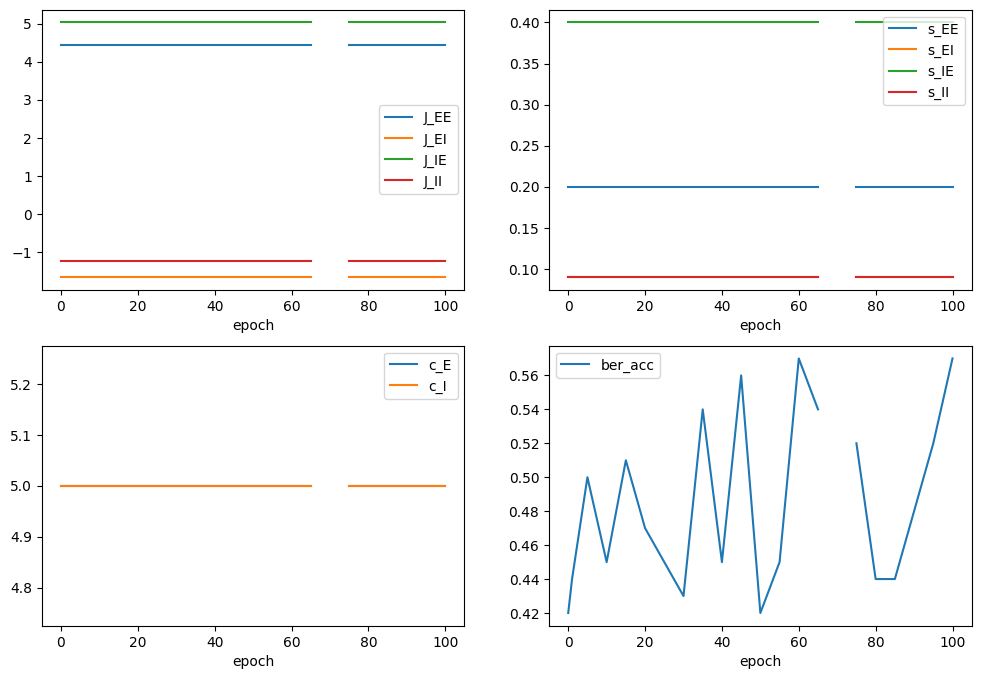

In [30]:
def plot_results(results_file, title=None):
    
    results = pd.read_csv(results_file, header = 0)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    results.plot(x='epoch', y=["J_EE", "J_EI", "J_IE", "J_II"], ax=axes[0,0])
    results.plot(x='epoch', y=["s_EE", "s_EI", "s_IE", "s_II"], ax = axes[0,1])
    results.plot(x='epoch', y=["c_E", "c_I"], ax = axes[1,0])
    results.plot(x='epoch', y = ['val_accuracy', 'ber_acc'], ax = axes[1,1])
 
    
    if title:
        fig.suptitle(title)
    fig.show()
    
    
plot_results(results)

In [38]:
results_ssn = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/regularizer_ssn_sig_noise1_offset10.csv'
opt='ssn'
final_ssn_layer_pars, final_readout_pars, val_loss_test, training_los_test= separate_train_SSN_vmap(new_ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results_ssn, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs, sig_noise = 1)

Before training  -- loss: 1.623974323272705, accuracy: 0.47999998927116394 
Saving results to csv  /mnt/d/temp/ssn_modelling/ssn-simulator/results/regularizer_ssn_sig_noise1_offset10.csv
Training loss: 147.3972625732422 ¦ Validation -- loss: 1.4420636892318726, accuracy: 0.5299999713897705 at epoch 1, (time 27.244821310043335)
Training loss: 148.7249755859375 ¦ Validation -- loss: 1.475020408630371, accuracy: 0.41999998688697815 at epoch 5, (time 27.823228359222412)
Training loss: 150.6509552001953 ¦ Validation -- loss: 1.5350384712219238, accuracy: 0.5400000214576721 at epoch 10, (time 27.48863697052002)
Training loss: 143.69915771484375 ¦ Validation -- loss: 1.6044939756393433, accuracy: 0.47999998927116394 at epoch 15, (time 27.019023418426514)
Training loss: 141.97352600097656 ¦ Validation -- loss: 1.4130245447158813, accuracy: 0.44999998807907104 at epoch 20, (time 27.07761287689209)
Training loss: 139.1031951904297 ¦ Validation -- loss: 1.4330196380615234, accuracy: 0.34999999403

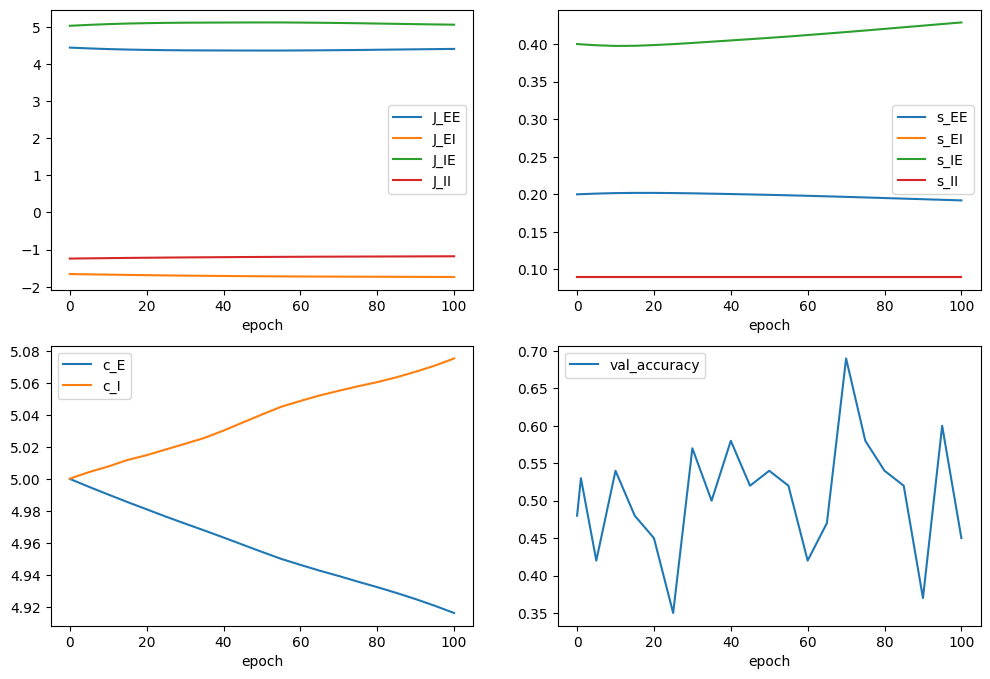

In [39]:
plot_results(results_ssn)

In [40]:
param_ratios(results_ssn)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [ 0  4  0 -4]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[0.95964719798236 1.0 1.07167525 1.0]
s ratios =  [-4  0  7  0]
